# Exercise 03 - Depth of Field (5+30+40+5+10+5=95 P)
Camera optics and lens effects are usually neglected when implementing a simple raytracer, so all it produces are images that are completely in focus and free from lens aberrations, essentially assuming a perfect pinhole camera. This is something not achievable with a real camera and therefore not perceived as a photographic look. However, it is very easy to extract depth information from a raytracer which can be used to add a depth-of-field effect.

In this exercise, you are going to create a synthetic Depth-of-Field (DoF) effect into a rendered picture of the famous Sponza Atrium in the Šibenik cathedral. To do so, you are given two images: An all-in-focus image of the Atrium and the corresponding depth map, which holds the distance from lens to surface point for each pixel. In order to create a proper looking picture, you need to add some DoF blur to it.

The __focal length__ of the lens, __radius__ of the lens __aperture__ and the __sensor size__ are provided in the given code-snippets. The desired __focusing distance__ is 1.

## Input and expected result
If you execute the next two cells you'll get an overview of the input images (a) and (b), a correctly raytraced image with depth of field (c) and the expected result you should get at the end of this exercise (d).

In [2]:
%matplotlib widget
import os

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from flt_reader import read_flt_image
from tqdm.notebook import tqdm

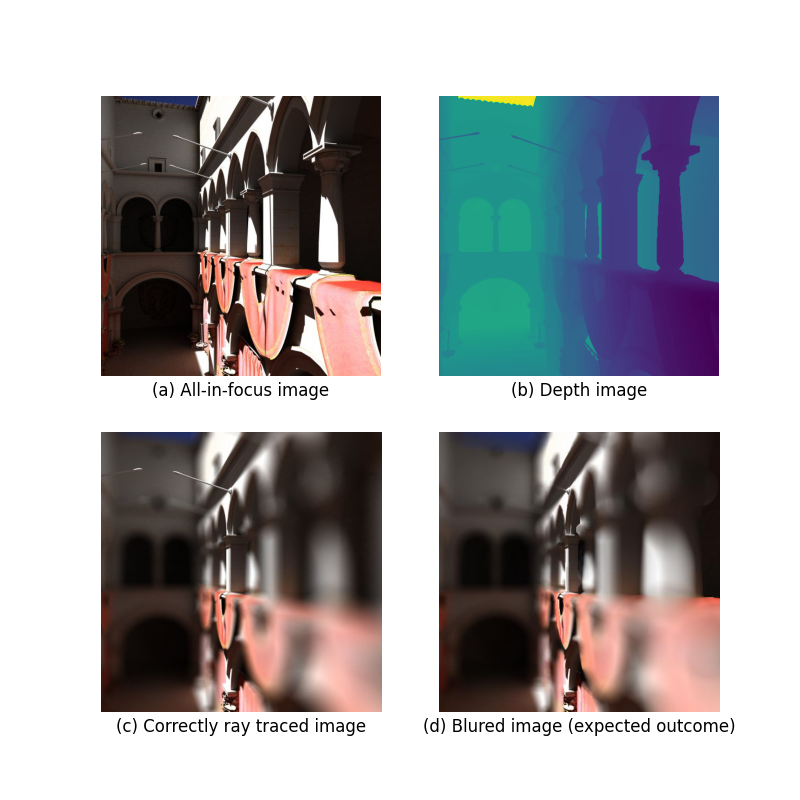

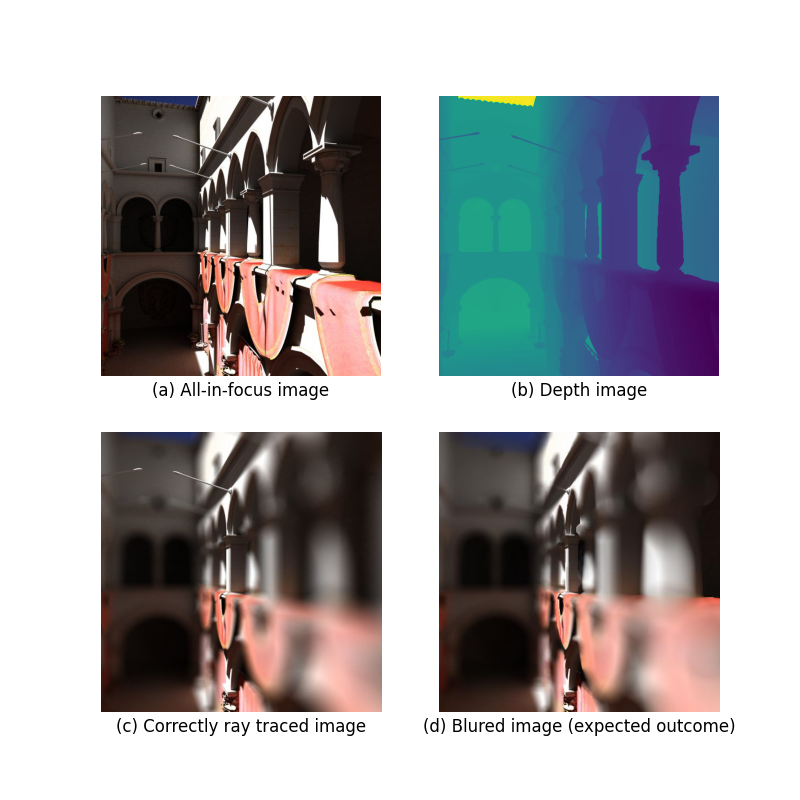

In [3]:
# load the images used to show the desired effect
all_in_focus = imageio.imread(os.path.join("images", "sponza_normal.jpg"))
depth_image = imageio.imread(os.path.join("images", "sponza_depth.jpg"))
correct_raytraced_image = imageio.imread(os.path.join("images", "sponza_correct.jpg"))
expected_outcome = imageio.imread(os.path.join("images", "sponza_blurred.jpg"))

fig, axs = plt.subplots(2, 2, figsize=[8, 8])
axs[0][0].imshow(all_in_focus)
axs[0][0].set_title("(a) All-in-focus image", y=-0.1)
axs[0][1].imshow(depth_image)
axs[0][1].set_title("(b) Depth image", y=-0.1)
axs[1][0].imshow(correct_raytraced_image)
axs[1][0].set_title("(c) Correctly ray traced image", y=-0.1)
axs[1][1].imshow(expected_outcome)
axs[1][1].set_title("(d) Blured image (expected outcome)", y=-0.1)
for i in range(2):
    for j in range(2):
        axs[i][j].set_axis_off()
fig.set
fig.show()

In [4]:
## The given camera parameters. You can play with the values, but make sure to set them back to the defaults before submitting!
# lens focal length, default: 0.02625
focal_length = 0.02625

# aperture radius, default: 0.05
aperture_radius = 0.05

# sensor x,y dimensions (square sensor surface, aspect ratio = 1) default: 0.024
sensor_size = 0.024

# distance from lens to plane of focus, default: 1
focus_distance = 1

# pixel width, height
pixel_size = sensor_size / all_in_focus.shape[0]

## Floating point input images to work with
all_in_focus = read_flt_image(os.path.join("images", "sponza_normal.flt"))
depth_image = read_flt_image(os.path.join("images", "sponza_depth.flt"))

### a) (5 P)
Compute the distance from the lens plane to the image plane (distance between the lens and the sensor).

In [5]:
# Thin lens equation: 1/f = 1/z + 1/z'
# for z = focus_distance we get the distance of the sensor to the lens
sensor_distance = 1  # TODO: Compute sensor distance
sensor_distance = 1 / (1 / focal_length - 1 / focus_distance)

print("sensor_distance: {}".format(sensor_distance))

sensor_distance: 0.026957637997432605


### b) (30 P)
For each pixel precompute the _circle of confusion_, which will be the radius of the blur kernel in the image plane (as a floating point value).
Convert the radii into pixel-units.

__HINT:__ This can be done without loops.

(512, 512, 3)
max_blur = 63


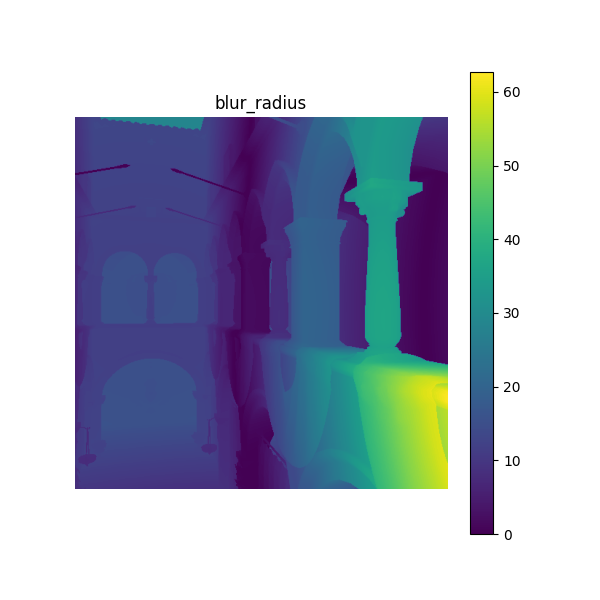

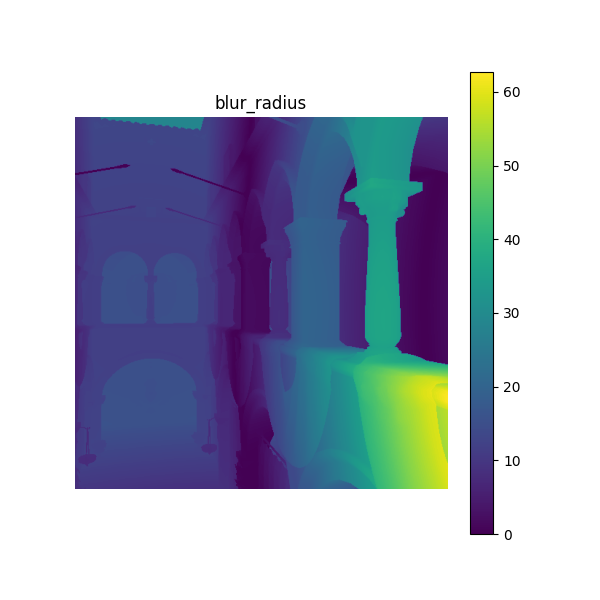

In [6]:
# precompute the blur kernel radii for all pixels
blur_radius = np.zeros_like(depth_image)  # TODO: compute the blur radius (circle of confusion)
print(all_in_focus.shape)
for y in range(len(all_in_focus)):
    for x in range(len(all_in_focus[y])):
        # Formula taken from https://en.wikipedia.org/wiki/Circle_of_confusion
        diameter = aperture_radius * 2 * (abs(depth_image[y][x] - focus_distance) / depth_image[y][x]) * (focal_length / (focus_distance - focal_length))
        blur_radius[y][x] = diameter / 2

# precompute the blur size (in pixels) for all pixels - the value of blur_radius
# in pixels
blur_radius_pixel = blur_radius / pixel_size  # TODO: convert radii to pixel units


# extract the maximum kernel size
max_blur = int(np.ceil(np.max(blur_radius_pixel)))

print("max_blur =", max_blur)

# show computed maps
fig_blur_radius = plt.figure(figsize=(6, 6))
ax = fig_blur_radius.add_subplot(111)
m_plot = ax.imshow(blur_radius_pixel)
ax.set_title("blur_radius")
ax.set_axis_off()
fig_blur_radius.colorbar(m_plot, ax=ax)
fig_blur_radius.show()

The function `blur_kernel(radius)` generates a blur-kernel that contains a mask for a circle-of-confusion with the given _radius_. You can use this function for the next task.

The figure created when executing the next cell gives you an impression on how the `blur_kernel` function behaves. A pixel is added to the kernel if at least half of its surface is within the circle defined by the radius. Feel free to experiment with different radii in the visualizations to see how they affect the kernels.

_Note: Don't be confused by the [type-hints](https://www.python.org/dev/peps/pep-0484/) in `blur_kernel`, they are used in python to explain what type of input is expected and what type of output is returned. The functionality is not changed._

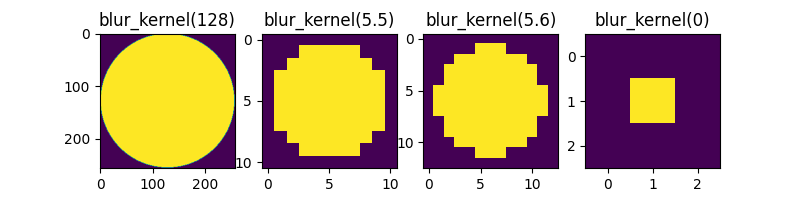

In [7]:
def blur_kernel(radius: float) -> np.ndarray:
    """Generates a circular kernel for the given blur-radius.

    The kernel always contains the center-pixel.

    Args:
        radius: Radius of the generated blur-kernel.
    Returns:
        A 2d-float-array, which contains 1 inside the radius (from the center) and 0 outside.
    """
    radius = max(radius - 0.5, 1e-6)
    line = np.linspace(np.floor(-radius), np.ceil(radius), 2 * int(np.ceil(radius)) + 1)
    xs, ys = np.meshgrid(line, line)
    points = np.stack([ys, xs], axis=-1)
    distances = np.linalg.norm(np.stack([ys, xs], axis=-1), axis=-1)
    mask = distances < radius
    return mask.astype(np.float32)


# plot some examples
fig_pad = plt.figure(figsize=(8, 2))
ax = fig_pad.add_subplot(141)
ax.imshow(blur_kernel(128))

ax.set_title("blur_kernel(128)")
ax = fig_pad.add_subplot(142)
ax.imshow(blur_kernel(5.5))

ax.set_title("blur_kernel(5.5)")
ax = fig_pad.add_subplot(143)
ax.imshow(blur_kernel(5.6))

ax.set_title("blur_kernel(5.6)")
ax = fig_pad.add_subplot(144)
ax.imshow(blur_kernel(0))

ax.set_title("blur_kernel(0)")
fig.show()

### c) 40 P
Splat each pixel value to its neighbors and update the `accumulation_buffer` to keep track of how many values were splatted to every pixel.
The splatting is to be performed using the given `blur_kernel` function for the blur-radius of each pixel.

_Note:_ The `blurred_image` and `accumulation_buffer` are larger to allow splatting into the border areas. The relevant part is cropped out in the end.
  Make sure to access those output arrays accordingly.

_Info: [tqdm](https://github.com/tqdm/tqdm#tqdm) is responsible for the beautiful progress bar._

In [9]:
# Allocate the depth-blurred image and the accumulation buffer
in_shape = all_in_focus.shape
out_shape = (in_shape[0] + 2 * max_blur, in_shape[1] + 2 * max_blur, in_shape[2])
blurred_image = np.zeros(out_shape, dtype=np.float32)
accumulation_buffer = np.zeros([out_shape[0], out_shape[1]], dtype=np.float32)

# Iterate over all all_in_focus pixels and splat them into the blurred image
for y in tqdm(range(all_in_focus.shape[0])):
    for x in range(all_in_focus.shape[0]):
        # TODO: lookup the blur radius for the current pixel
        blur_radius_value = blur_radius_pixel[y][x]

        # TODO: get the current blur kernel
        blur_kernel_value = blur_kernel(blur_radius_value)
        
        # TODO: perform the splatting in image space
        shape = blur_kernel_value.shape
        y_half = shape[0] // 2
        x_half = shape[1] // 2
        for y_kernel in range(shape[0]):
            for x_kernel in range(shape[1]):
                if blur_kernel_value[y_kernel][x_kernel] > 0:
                    splat_y = y - y_half + y_kernel
                    splat_x = x - x_half + x_kernel

                    blurred_image[splat_y][splat_x] += blur_kernel_value[y_kernel][x_kernel] * all_in_focus[y][x]

                    # TODO: update the accumulation buffer
                    accumulation_buffer[splat_y][splat_x] += 1

# cut out center
blurred_image = blurred_image[max_blur:-max_blur, max_blur:-max_blur]
accumulation_buffer = accumulation_buffer[max_blur:-max_blur, max_blur:-max_blur]

  0%|          | 0/512 [00:00<?, ?it/s]

### d) (5 P)
Finally normalize the blurred image using the `accumulation_buffer`.

In [13]:
blurred_image_normalized = np.zeros_like(all_in_focus)  # TODO normalize blurred image
blurred_image_normalized = blurred_image / (accumulation_buffer[:, :, np.newaxis] + 1e-6)

### e) (10 P)
Visually compare the result you obtained with the provided image which has been correctly ray traced using
a thin lens model.

What is the reason for the differences to the ray-traced version shown above? Could they be solved by changing the algorithm and how so?
Write your answer as text into the given Markdown cell.

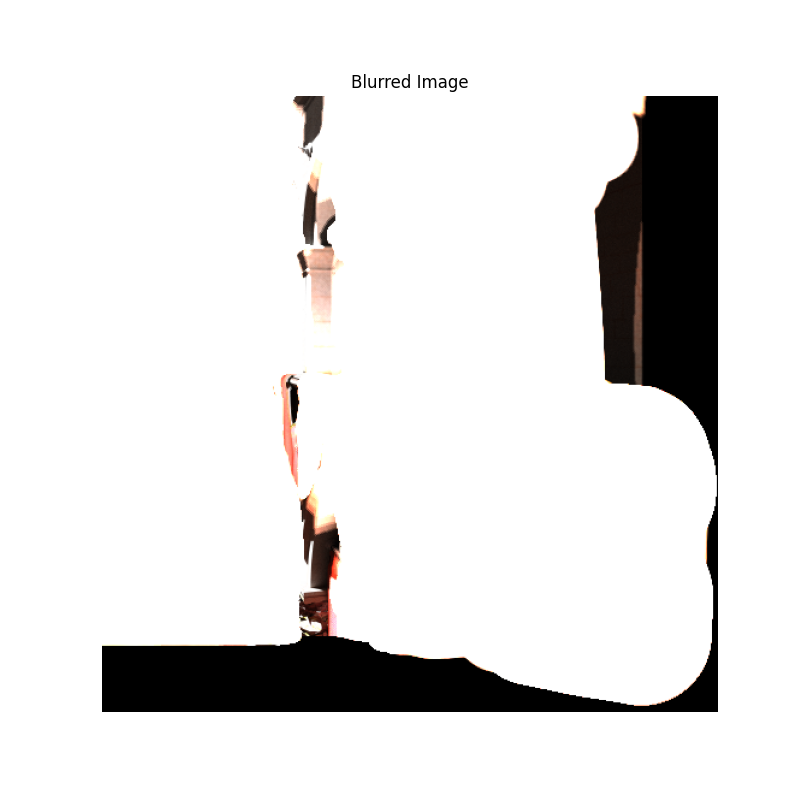

In [14]:
# TODO: Make some plots
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.clip(blurred_image, 0, 1))
ax.set_title("Blurred Image")
ax.axis('off')
plt.show()

TODO: Put your text answers here!


### f) (5 P)
Now your image looks more like a photograph. Still some other aberrations are missing from the synthetic image.
Name two aberrations that are easy to approximate in image space and explain how it could be implemented. There is no need to write any code here.

Chromatic Aberrations:
We can simulate the refraction of different wavelength in light by splitting the different color channels rgb and calculate their refractions in the lens with a slight offset per color channel.

Radial Falloff (Vignetting):
We can simulate the natural falloff of the light caused by vignetting by reducing/scaling the brightness based on the distance to the center point. For this we can use a round brightness mask and apply it to the image. This will create a vignetting like effect.

## Links:

Depth of field is nicely explained [here](http://www.cambridgeincolour.com/tutorials/depth-of-field.htm).